<a href="https://colab.research.google.com/github/khaled-kk/Customer-Segmentation-and-Profiling-RetailX-Case/blob/main/RetailX_Customer_Segmentation_and_Classification_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 0. Setup
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# 1. Load data
df = pd.read_csv('/content/RetailX_KM(segmentation_result).csv')  # replace with your path

In [ ]:
# 2. Define behavioral features only (base for clustering)
behavioral_feats = [
    'avg_order_size', 'avg_order_freq', 'crossbuy', 'multichannel',
    'per_sale', 'tenure', 'return_rate', 'loyalty_card', 'avg_mktg_cnt'
]

In [ ]:
# 3. Standardize behavioral features
scaler = StandardScaler()
X_clust = pd.DataFrame(scaler.fit_transform(df[behavioral_feats]), columns=behavioral_feats)

print("Using these features for clustering:", behavioral_feats)

Using these features for clustering: ['avg_order_size', 'avg_order_freq', 'crossbuy', 'multichannel', 'per_sale', 'tenure', 'return_rate', 'loyalty_card', 'avg_mktg_cnt']


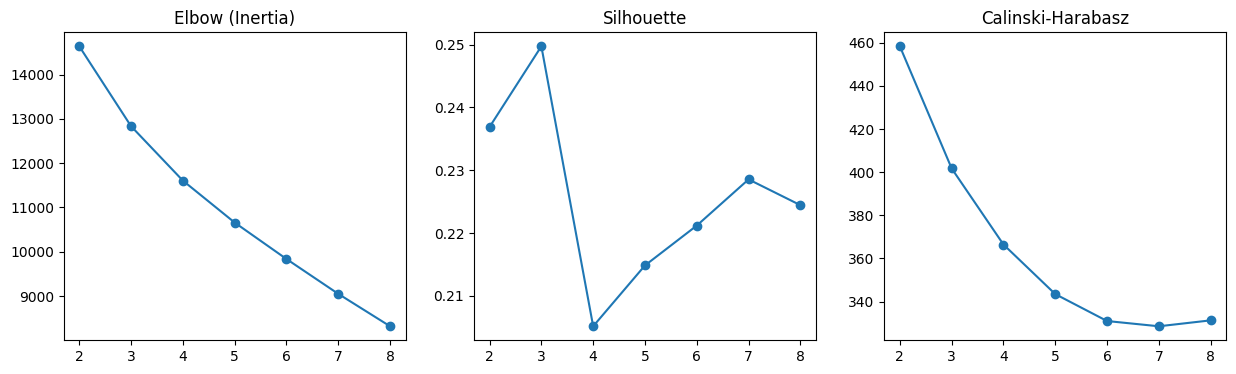

In [ ]:
# 4. Choose k via elbow + silhouette + CH
inertias, sils, chs = [], [], []
Ks = range(2, 9)
for k in Ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_clust)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_clust, labels))
    chs.append(calinski_harabasz_score(X_clust, labels))

fig, axs = plt.subplots(1,3,figsize=(15,4))
axs[0].plot(Ks, inertias, marker='o'); axs[0].set_title('Elbow (Inertia)')
axs[1].plot(Ks, sils, marker='o'); axs[1].set_title('Silhouette')
axs[2].plot(Ks, chs, marker='o'); axs[2].set_title('Calinski-Harabasz')
plt.show()

In [ ]:
# 5. Fit final KMeans
k_final = 3  # set based on metrics inspection
km = KMeans(n_clusters=k_final, n_init=50, random_state=42)
df['segment'] = km.fit_predict(X_clust)

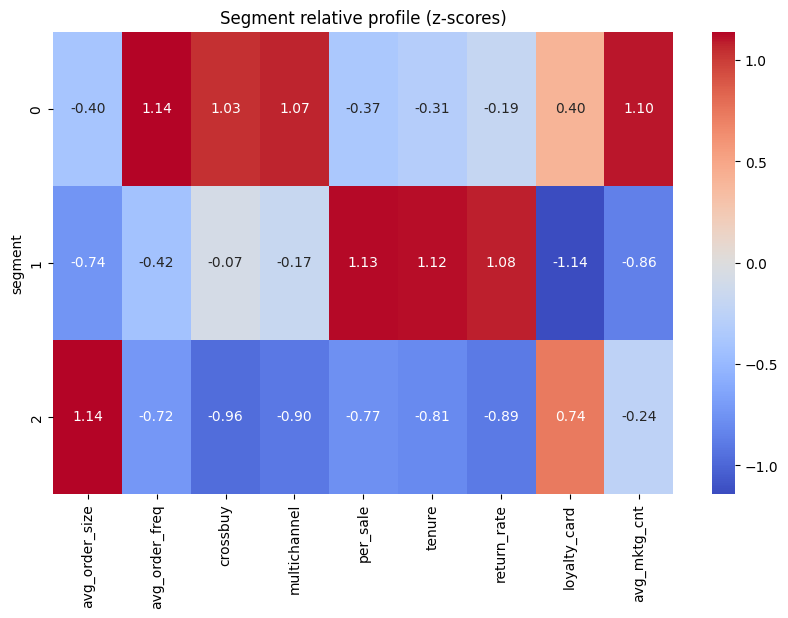

In [ ]:
# 6. Profiling: use descriptive features to interpret segments
descriptive_feats = ['income','age','household_size','married','own_home','zip_code']
profile = df.groupby('segment')[behavioral_feats + descriptive_feats].agg(['mean','median'])
#print(profile)

# Relative heatmap (behavioral features only)
rel_means = df.groupby('segment')[behavioral_feats].mean()
rel_means_z = (rel_means - rel_means.mean()) / rel_means.std()
plt.figure(figsize=(10,6))
sns.heatmap(rel_means_z, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Segment relative profile (z-scores)')
plt.show()

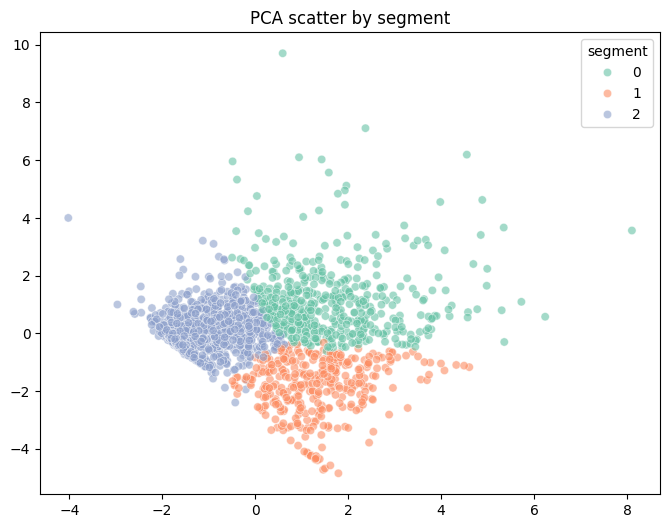

In [ ]:
# 7. 2D visualization via PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_clust)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['segment'], palette='Set2', alpha=0.6)
plt.title('PCA scatter by segment')
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



LogReg report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       144
           1       0.99      0.99      0.99       106
           2       0.99      0.99      0.99       350

    accuracy                           0.99       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.99      0.99      0.99       600

Confusion matrix:
 [[140   1   3]
 [  1 105   0]
 [  3   0 347]]

Tree report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       144
           1       0.92      0.87      0.89       106
           2       0.95      0.97      0.96       350

    accuracy                           0.94       600
   macro avg       0.92      0.91      0.92       600
weighted avg       0.93      0.94      0.93       600

Confusion matrix:
 [[130   5   9]
 [  7  92   7]
 [  8   3 339]]

RF report:
               precision    recall  f1-score   support

        

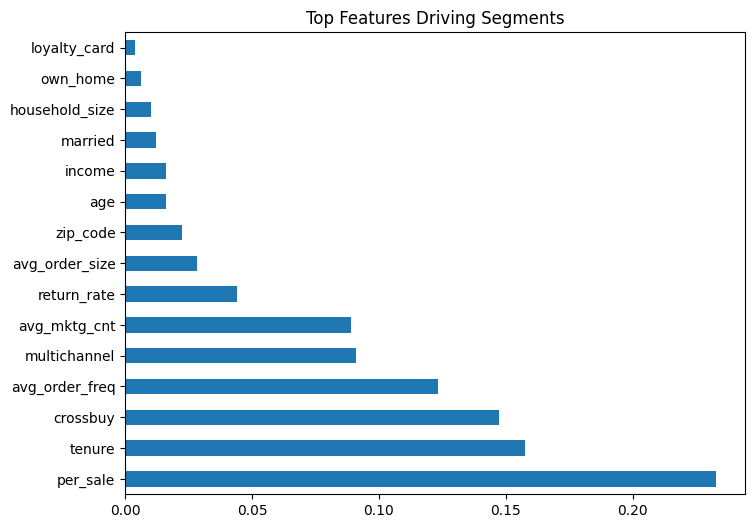

In [ ]:
# 8. Classification: predict segment membership
# Use both behavioral + descriptive features for prediction
predictors = behavioral_feats + descriptive_feats
X_full = pd.DataFrame(StandardScaler().fit_transform(df[predictors]), columns=predictors)
y = df['segment']

X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=42, stratify=y)

models = {
    'LogReg': LogisticRegression(max_iter=2000, multi_class='multinomial'),
    'Tree': DecisionTreeClassifier(random_state=42),
    'RF': RandomForestClassifier(n_estimators=300, random_state=42)
}

results = []
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    results.append((name, acc, f1))
    print(f'\n{name} report:\n', classification_report(y_test, preds))
    print('Confusion matrix:\n', confusion_matrix(y_test, preds))

print('\nModel comparison:', results)

# Feature importance (for RF)
importances = pd.Series(models['RF'].feature_importances_, index=X_full.columns)

# Show top clustering drivers clearly
top_features = importances.sort_values(ascending=False)
print("\nTop clustering drivers:\n", top_features.head(16))

# Optional: visualize as a bar chart
top_features.head(16).plot(kind='barh', figsize=(8,6), title="Top Features Driving Segments")
plt.show()

